In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import warnings
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')    # 警告メッセージを無視

In [2]:
# ========== 初期設定 (初始化设置) ==========

# pandasですべての列を表示するように設定（省略なし）
pd.set_option('display.max_columns', None) 
# 乱数シードを42に固定（再現性のため）
np.random.seed(42) 

# 保存パスの設定読み込み
DATA_PATH = 'data-14-01.xlsx'
OUTPUT_PATH = 'processed_data.xlsx'  

In [3]:
# ========== データの読み込みと検証 (数据加载与校验) ==========

# データ読み込み
df = pd.read_excel(DATA_PATH)
print(f"数据加载成功，原始形状：{df.shape}") #データ読み込み成功、元の形状

数据加载成功，原始形状：(41692, 108)


In [4]:
# ========== データクリーニング (数据清洗) ==========

# 1. 不要なフィールドの削除
# CLLI_OID 一意識別子、特徴の汎化能力なし
# CL_NO 請求番号、純粋な管理番号 
# LINE_NO 請求明細行番号、分析価値なし
# FX_RATE 為替レート（国内業務は1に固定）、実質的な意味なし  
# SCMA_OID_BEN_TYPE BEN_TYPEと重複、冗長フィールド 
# BARCODE 個別案件コード、一意識別子
# PRI_CORR_BRKR_NAME 固定値“BSI”、分析価値なし
# CRT_USER 作成者、ユーザー行動とは無関係
# UPD_USER 更新者、ユーザー行動とは無関係
# ID_CARD_NO 身分証番号、プライバシーコンプライアンスリスクあり
# PHONE_NO 電話番号、プライバシーコンプライアンスリスクあり
# PAYEE_LAST_NAME 受取人姓、プライバシーコンプライアンスリスクあり 
# PAYEE_FIRST_NAME 受取人名、プライバシーコンプライアンスリスクあり
# LINE_REMARK 非構造化テキスト、NLP処理が必要で利益は不確定                    
# CSR_REMARK 非構造化テキスト、NLP処理が必要で利益は不確定                    
# PLAN_REMARK 非構造化テキスト、NLP処理が必要で利益は不確定   
# その他、分析に不要と思われる列定義
# MAN_REJ_CODE_DESC_
# CL_LINE_FORMULA
# CL_CLAIM_FORMULA
# CL_INVOICE_FORMULA
# CL_PAY_ACCT_NO
# KIND_CODE
# POCY_REF_NO
# MBR_REF_NO
# CLSH_HOSP_CODE
# MAN_REJ_CODE_DESC_1
# MAN_REJ_CODE_DESC_2
# BEN_HEAD_TYPE
# MBR_REF_NO_B
# ORG_INSUR_INVOICE_IND
# FILE_ID
# MEPL_MBR_REF_NO
# MEPL_MBR_REF_NO_B
# MBR_LAST_NAME      
# BANK_NAME           
# CL_PAY_ACCT_NAME
cols_to_drop = ['CLLI_OID', 'CL_NO', 'LINE_NO', 'BARCODE', 'FX_RATE','PRI_CORR_BRKR_NAME','SCMA_OID_BEN_TYPE', 'CRT_USER', 'UPD_USER',
                'ID_CARD_NO', 'PHONE_NO', 'PAYEE_LAST_NAME', 'PAYEE_FIRST_NAME','CL_PAY_ACCT_NO','POCY_REF_NO','MBR_REF_NO','CLSH_HOSP_CODE',
                'LINE_REMARK', 'CSR_REMARK', 'PLAN_REMARK','MAN_REJ_CODE_DESC_','CL_LINE_FORMULA','CL_CLAIM_FORMULA','CL_INVOICE_FORMULA',
               'KIND_CODE','MAN_REJ_CODE_DESC_1','MAN_REJ_CODE_DESC_2','BEN_HEAD_TYPE','MBR_REF_NO_B','ORG_INSUR_INVOICE_IND','FILE_ID'
               'MEPL_MBR_REF_NO','MEPL_MBR_REF_NO_B','MBR_LAST_NAME  ','BANK_NAME','CL_PAY_ACCT_NAME','FILE_ID ','MAN_REJ_AMT_2',
               'FILE_CLOSE_DATE','TOTAL_RECEIPT_AMT','MEPL_MBR_REF_NO','MAN_REJ_AMT_1','PROV_DEPT','MBR_LAST_NAME','FILE_ID','WORKPLACE_NAME',
                'POCY_PLAN_DESC','INCUR_DATE_FROM','INCUR_DATE_TO','PAY_DATE','CRT_DATE','UPD_DATE','DIAG_DESC','SCMA_OID_CL_LINE_STATUS',
               'RCV_DATE','MBR_FIRST_NAME','SCMA_OID_PROD_TYPE','SCMA_OID_CL_STATUS','SCMA_OID_CL_TYPE','SCMA_OID_COUNTRY_TREATMENT','MEMBER_EVENT',
               'INSUR_INVOICE_IND','PROV_NAME','MBR_TYPE','BOX_BARCODE','PAY_AMT','STR_CRT_DATE','ORG_PRES_AMT','PROV_CODE','MBR_NO','STR_UPD_DATE','POHO_NO',
                'POPL_OID','INVOICE_ID','CL_LINE_NO','PLAN_OID','POCY_NO','POLICY_CNT','INVOICE_NO'
               ,'BEN_HEAD','RJ_CODE_LIST','RECHARGE_AMT']
# 実際にデータフレームに存在する列のみを削除リストに含める
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True) # inplace=Trueは元のDataFrameを直接変更することを意味する
print(f"已删除字段：{cols_to_drop}") #削除されたフィールド


# 2. 目的変数のエンコーディング
# 詐欺かどうかを変更 'AC' → 0（非詐欺、つまり正常な請求） 'RJ' → 1（詐欺、つまり疑わしい、または拒否された案件）
# 'PD' と 'PV' も 1 (詐欺/異常) として扱う
if 'CL_LINE_STATUS' in df.columns:
    df['fraud'] = df['CL_LINE_STATUS'].map({'AC': 0, 'RJ': 1,'PD':1,'PV':1})
    df.drop(columns=['CL_LINE_STATUS'], inplace=True)

已删除字段：['CLLI_OID', 'CL_NO', 'LINE_NO', 'BARCODE', 'FX_RATE', 'PRI_CORR_BRKR_NAME', 'SCMA_OID_BEN_TYPE', 'CRT_USER', 'UPD_USER', 'ID_CARD_NO', 'PHONE_NO', 'PAYEE_LAST_NAME', 'PAYEE_FIRST_NAME', 'CL_PAY_ACCT_NO', 'POCY_REF_NO', 'MBR_REF_NO', 'CLSH_HOSP_CODE', 'LINE_REMARK', 'CSR_REMARK', 'PLAN_REMARK', 'CL_LINE_FORMULA', 'CL_CLAIM_FORMULA', 'CL_INVOICE_FORMULA', 'KIND_CODE', 'MAN_REJ_CODE_DESC_1', 'MAN_REJ_CODE_DESC_2', 'BEN_HEAD_TYPE', 'MBR_REF_NO_B', 'ORG_INSUR_INVOICE_IND', 'MEPL_MBR_REF_NO_B', 'BANK_NAME', 'CL_PAY_ACCT_NAME', 'MAN_REJ_AMT_2', 'FILE_CLOSE_DATE', 'TOTAL_RECEIPT_AMT', 'MEPL_MBR_REF_NO', 'MAN_REJ_AMT_1', 'PROV_DEPT', 'MBR_LAST_NAME', 'FILE_ID', 'WORKPLACE_NAME', 'POCY_PLAN_DESC', 'INCUR_DATE_FROM', 'INCUR_DATE_TO', 'PAY_DATE', 'CRT_DATE', 'UPD_DATE', 'DIAG_DESC', 'SCMA_OID_CL_LINE_STATUS', 'RCV_DATE', 'MBR_FIRST_NAME', 'SCMA_OID_PROD_TYPE', 'SCMA_OID_CL_STATUS', 'SCMA_OID_CL_TYPE', 'SCMA_OID_COUNTRY_TREATMENT', 'MEMBER_EVENT', 'INSUR_INVOICE_IND', 'PROV_NAME', 'MBR_TYPE'

In [5]:
# ========== 欠損値処理 (缺失值处理) ==========

# 1. すべて空の列を削除
# df.isnull().all()：各列がすべて空値かどうかをチェックし、ブールSeriesを返す
# df.columns[df.isnull().all()]：値がTrueである列名をフィルタリングする
empty_cols = df.columns[df.isnull().all()].tolist()
if empty_cols:
    df.drop(empty_cols, axis=1, inplace=True)
    print(f"已删除全空列：{empty_cols}") #すべて空のため削除された列

# 2. 初期の欠損値統計を出力
# 各列の欠損値数をカウントし、降順に並べ替える
print("\n缺失值统计（处理前）：") #欠損値統計（処理前）
missing_stats = df.isnull().sum().sort_values(ascending=False)
print(missing_stats[missing_stats > 0] if missing_stats.any() else "无缺失值") #欠損値なし

# 数値型フィールド：中央値で埋める
# select_dtypes(include=['int64', 'float64']) すべての整数および浮動小数点列を選択
# .columns これらの列の名前リストを取得
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    # その列に少なくとも1つの欠損値が存在するか判断
    if df[col].isnull().any():
        # その列の中央値を計算
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"数值字段 [{col}] 用中位数填充：{median_val:.2f}") #数値フィールド [{col}] を中央値で埋める

# カテゴリ型フィールド：最頻値で埋める
# select_dtypes(include=['object', 'category']) すべてのテキストおよびカテゴリタイプの列を選択
# .columns これらの列の名前リストを取得
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if df[col].isnull().any():
        # その列で最も出現頻度の高い値を計算
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"类别字段 [{col}] 用众数填充：{mode_val}") #カテゴリフィールド [{col}] を最頻値で埋める

# 3. 処理結果の検証
print("\n缺失值统计（处理后）：") #欠損値統計（処理後）
remaining_missing = df.isnull().sum().sum()
print(f"{remaining_missing} 个剩余缺失值" if remaining_missing > 0 else "无剩余缺失值")
#个剩余缺失值 (残りの欠損値)  无剩余缺失值 (残りの欠損値なし)

已删除全空列：['PAYMENT_STATUS', 'PAYMENT_AMENT_DATE', 'MAN_REJ_CODE_DESC_3', 'MAN_REJ_CODE_DESC_4', 'MAN_REJ_CODE_DESC_5', 'MAN_REJ_AMT_3', 'MAN_REJ_AMT_4', 'MAN_REJ_AMT_5', 'INVOICE_RTN_IND', 'AMT_DAY_USED', 'PAY_PCT_LIST']

缺失值统计（处理前）：
DED_AMT         994
CODES           264
APP_AMT         201
BEN_SPEND       201
PAY_AMT_USD     201
REJECTED_AMT    201
PROV_LEVEL       29
dtype: int64
数值字段 [APP_AMT] 用中位数填充：20.40
数值字段 [BEN_SPEND] 用中位数填充：20.40
数值字段 [PAY_AMT_USD] 用中位数填充：20.40
数值字段 [REJECTED_AMT] 用中位数填充：-4.60
数值字段 [DED_AMT] 用中位数填充：0.00
类别字段 [CODES] 用众数填充：R530, W055
类别字段 [PROV_LEVEL] 用众数填充：三级

缺失值统计（处理后）：
无剩余缺失值


In [6]:
# ========== 外れ値処理（3σ法） (异常值处理（3σ原则）) ==========

print("\n开始异常值处理（3σ原则）...") #外れ値処理（3σ法）を開始...
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = [c for c in num_cols if c != 'fraud'] # 目的変数を除外

for col in num_cols:
    # 平均と標準偏差を計算
    mean = df[col].mean()
    std = df[col].std()
    
    # 3σの境界を定義
    lower_bound = mean - 3*std
    upper_bound = mean + 3*std
    
    # 外れ値を特定
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()
    
    if outlier_count > 0:
        print(f"字段 [{col}] 发现 {outlier_count} 个异常值（{outlier_count/len(df):.2%}），使用边界值替换")
        
        # 外れ値を境界値で置換
        df.loc[df[col] < lower_bound, col] = lower_bound
        df.loc[df[col] > upper_bound, col] = upper_bound


开始异常值处理（3σ原则）...
字段 [ORG_PRES_AMT_VALUE] 发现 18 个异常值（0.04%），使用边界值替换
字段 [APP_AMT] 发现 9 个异常值（0.02%），使用边界值替换
字段 [BEN_SPEND] 发现 9 个异常值（0.02%），使用边界值替换
字段 [PAY_AMT_USD] 发现 9 个异常值（0.02%），使用边界值替换
字段 [REJECTED_AMT] 发现 67 个异常值（0.16%），使用边界值替换
字段 [SUB_AMT] 发现 56 个异常值（0.13%），使用边界值替换
字段 [CL_SOCIAL_PAY_AMT] 发现 175 个异常值（0.42%），使用边界值替换
字段 [CL_THIRD_PARTY_PAY_AMT] 发现 68 个异常值（0.16%），使用边界值替换
字段 [CL_OWNER_PAY_AMT] 发现 45 个异常值（0.11%），使用边界值替换
字段 [CL_SELF_CAT_PAY_AMT] 发现 66 个异常值（0.16%），使用边界值替换
字段 [CWF_AMT_DAY] 发现 118 个异常值（0.28%），使用边界值替换
字段 [DED_AMT] 发现 265 个异常值（0.64%），使用边界值替换
字段 [NO_OF_YR] 发现 21 个异常值（0.05%），使用边界值替换
字段 [INVOICE_CNT] 发现 924 个异常值（2.22%），使用边界值替换


In [7]:
from sklearn.preprocessing import MinMaxScaler

# すべての数値型列を選択（目的変数 'fraud' を除く）
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col != 'fraud']

# MinMaxScalerの初期化
scaler = MinMaxScaler()

# 選択した列に対してMin-Max正規化を行う
df[num_cols] = scaler.fit_transform(df[num_cols])

# 正規化後のデータ範囲を確認
print("Min-Max 标准化后的数据范围：") #Min-Max正規化後のデータ範囲
print(df[num_cols].describe().loc[['min', 'max']])


Min-Max 标准化后的数据范围：
     ORG_PRES_AMT_VALUE  APP_AMT  BEN_SPEND  PAY_AMT_USD  REJECTED_AMT  \
min                 0.0      0.0        0.0          0.0           0.0   
max                 1.0      1.0        1.0          1.0           1.0   

     SUB_AMT  CL_SOCIAL_PAY_AMT  CL_THIRD_PARTY_PAY_AMT  CL_OWNER_PAY_AMT  \
min      0.0                0.0                     0.0               0.0   
max      1.0                1.0                     1.0               1.0   

     CL_SELF_CAT_PAY_AMT  COPAY_PCT  CWF_AMT_DAY  DED_AMT  NO_OF_YR  \
min                  0.0        0.0          0.0      0.0       0.0   
max                  1.0        1.0          1.0      1.0       1.0   

     INVOICE_CNT  
min          0.0  
max          1.0  


In [8]:
# 特徴量エンコーディング (特征编码)
from sklearn.preprocessing import LabelEncoder

# PROV_LEVEL に対して特徴量エンコーディングを行う
if 'PROV_LEVEL' in df.columns:
    # PROV_LEVEL に対して特徴量エンコーディングを行う
    label_encoder = LabelEncoder()
    
    # PROV_LEVEL をエンコード
    df['PROV_LEVEL'] = label_encoder.fit_transform(df['PROV_LEVEL'])
    
    # PROV_LEVEL をエンコード
    print("PROV_LEVEL 编码映射关系：") #PROV_LEVEL エンコーディングマッピング関係
    for i, label in enumerate(label_encoder.classes_):
        print(f"{label} → {i}")



# BEN_TYPE に対して特徴量エンコーディングを行う
if 'BEN_TYPE' in df.columns:
    # BEN_TYPE の一意な値を統計
    unique_ben_types = df['BEN_TYPE'].unique()
    print(f"BEN_TYPE 的唯一值有 {len(unique_ben_types)} 种，具体为：{unique_ben_types}")
    
    # LabelEncoderの初期化
    label_encoder = LabelEncoder()
    
    # BEN_TYPE をエンコード
    df['BEN_TYPE'] = label_encoder.fit_transform(df['BEN_TYPE'])
    
    # エンコーディングのマッピング関係を出力
    print("BEN_TYPE 编码映射关系：")
    for i, label in enumerate(label_encoder.classes_):
        print(f"{label} → {i}")



# DIAG_CODE に対して特徴量エンコーディングを行う（最初の1文字に基づく）
if 'DIAG_CODE' in df.columns:
    # 最初の1文字を分類の根拠として抽出
    df['DIAG_CODE_PREFIX'] = df['DIAG_CODE'].str[:1]
    
    # 最初の1文字の一意な値を統計
    unique_prefixes = df['DIAG_CODE_PREFIX'].unique()
    print(f"DIAG_CODE 的前1个字符有 {len(unique_prefixes)} 种，具体为：{unique_prefixes}")
    
    # LabelEncoderの初期化
    label_encoder = LabelEncoder()
    
    # 最初の1文字をエンコード
    df['DIAG_CODE_PREFIX'] = label_encoder.fit_transform(df['DIAG_CODE_PREFIX'])
    
    # エンコーディングのマッピング関係を出力
    print("DIAG_CODE 前1个字符编码映射关系：")
    for i, label in enumerate(label_encoder.classes_):
        print(f"{label} → {i}")
    
    # 元の DIAG_CODE 列を削除（必要に応じて）
    df.drop(columns=['DIAG_CODE'], inplace=True)


# 1. CODES 列が存在するか確認
if 'CODES' in df.columns:
    # 2. 欠損値を埋めて文字列に変換
    df['CODES'] = df['CODES'].fillna('').astype(str)
    
    # 3. カンマ区切りの文字列数を計算して新しい特徴量とする
    df['CODES_COUNT'] = df['CODES'].apply(lambda x: len(x.split(',')) if x else 0)
    
    # 4. 元の CODES 列を削除（必要に応じて）
    df.drop(columns=['CODES'], inplace=True)
    
    print("CODES 列已编码为字符串数量，新增列：CODES_COUNT") #CODES列は文字列数としてエンコードされました、追加列
else:
    print("数据中未找到 CODES 列，请检查数据！") #データにCODES列が見つかりません、データを確認してください！

PROV_LEVEL 编码映射关系：
一级 → 0
三级 → 1
二级 → 2
医保 → 3
卫生所 → 4
未知 → 5
未评级 → 6
特需 → 7
非医保 → 8
BEN_TYPE 的唯一值有 15 种，具体为：['OP' 'IP' 'MA' 'MT' 'DT' 'YW-OP' 'VS' 'IPCASB' 'MEMR' 'JW-OP' 'PA'
 'YW-IP' 'MDB' 'GG-OP' 'GG-IP']
BEN_TYPE 编码映射关系：
DT → 0
GG-IP → 1
GG-OP → 2
IP → 3
IPCASB → 4
JW-OP → 5
MA → 6
MDB → 7
MEMR → 8
MT → 9
OP → 10
PA → 11
VS → 12
YW-IP → 13
YW-OP → 14
DIAG_CODE 的前1个字符有 26 种，具体为：['J' 'P' 'M' 'F' 'R' 'Z' 'K' 'O' 'N' 'I' 'L' 'H' 'B' 'T' 'A' 'G' 'X' 'C'
 'S' nan 'E' 'W' 'Y' 'D' 'Q' '4']
DIAG_CODE 前1个字符编码映射关系：
4 → 0
A → 1
B → 2
C → 3
D → 4
E → 5
F → 6
G → 7
H → 8
I → 9
J → 10
K → 11
L → 12
M → 13
N → 14
O → 15
P → 16
Q → 17
R → 18
S → 19
T → 20
W → 21
X → 22
Y → 23
Z → 24
nan → 25
CODES 列已编码为字符串数量，新增列：CODES_COUNT


In [9]:
# ========== データ出力 (数据输出) ==========

# 出力ディレクトリが存在することを確認
os.makedirs(os.path.dirname(OUTPUT_PATH) or '.', exist_ok=True)

# 処理後のデータを保存
df.to_excel(OUTPUT_PATH, index=False)
print(f"\n数据处理完成，结果已保存到: {os.path.abspath(OUTPUT_PATH)}") #データ処理完了、結果保存先
print(f"最终数据形状：{df.shape}") #最終データ形状


数据处理完成，结果已保存到: C:\Users\27826\Desktop\项目\数据预处理，特征工程\processed_data.xlsx
最终数据形状：(41692, 20)


In [10]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# 1. 特徴量抽出
if 'fraud' in df.columns:
    # 特徴量変数（X）を抽出：目的変数を除外
    X = df.drop(columns=['fraud'])
    
    # 目的変数（y）を抽出：Fraud 列
    y = df['fraud']
    
    # 2. 特徴量評価（カイ二乗検定を使用）
    # SelectKBestの初期化、すべての特徴量を選択してスコアリング
    selector = SelectKBest(score_func=chi2, k='all')
    
    # 特徴量スコアとp値を計算
    selector.fit(X, y)
    
    # 特徴量スコア結果とp値を取得
    feature_scores = pd.DataFrame({
        'feature': X.columns,
        'Score': selector.scores_,  # カイ二乗統計量
        'P值': selector.pvalues_    # p値
    }).sort_values(by='Score', ascending=False)
    
    # 特徴量スコア結果を出力
    print("特征评分结果（基于卡方检验）：") #特徴量スコア結果（カイ二乗検定に基づく）
    print(feature_scores)
else:
    print("数据中未找到 fraud 列，请检查数据！") #データにfraud列が見つかりません、データを確認してください！

特征评分结果（基于卡方检验）：
                   feature        Score             P值
12              PROV_LEVEL  1089.656727  5.847170e-239
16             INVOICE_CNT   322.303651   4.561647e-72
8   CL_THIRD_PARTY_PAY_AMT   230.044009   5.831024e-52
13             CWF_AMT_DAY   165.876927   5.885051e-38
18             CODES_COUNT    56.497626   5.626627e-14
9         CL_OWNER_PAY_AMT    42.125667   8.559238e-11
3              PAY_AMT_USD    24.397043   7.838891e-07
1                  APP_AMT    24.395940   7.843383e-07
2                BEN_SPEND    24.394491   7.849282e-07
17        DIAG_CODE_PREFIX    15.632484   7.692177e-05
5                 BEN_TYPE     9.014190   2.678916e-03
14                 DED_AMT     8.630108   3.306520e-03
10     CL_SELF_CAT_PAY_AMT     3.490121   6.173607e-02
15                NO_OF_YR     2.010039   1.562613e-01
6                  SUB_AMT     1.963915   1.610952e-01
4             REJECTED_AMT     1.470085   2.253322e-01
7        CL_SOCIAL_PAY_AMT     0.506822   4.76517

In [11]:
# p値が0.05未満の特徴量を抽出
significant_features = feature_scores[feature_scores['P值'] < 0.05]

# 結果を出力
print("p 值小于 0.05 的特征：") #p値が0.05未満の特徴量
print(significant_features)

p 值小于 0.05 的特征：
                   feature        Score             P值
12              PROV_LEVEL  1089.656727  5.847170e-239
16             INVOICE_CNT   322.303651   4.561647e-72
8   CL_THIRD_PARTY_PAY_AMT   230.044009   5.831024e-52
13             CWF_AMT_DAY   165.876927   5.885051e-38
18             CODES_COUNT    56.497626   5.626627e-14
9         CL_OWNER_PAY_AMT    42.125667   8.559238e-11
3              PAY_AMT_USD    24.397043   7.838891e-07
1                  APP_AMT    24.395940   7.843383e-07
2                BEN_SPEND    24.394491   7.849282e-07
17        DIAG_CODE_PREFIX    15.632484   7.692177e-05
5                 BEN_TYPE     9.014190   2.678916e-03
14                 DED_AMT     8.630108   3.306520e-03


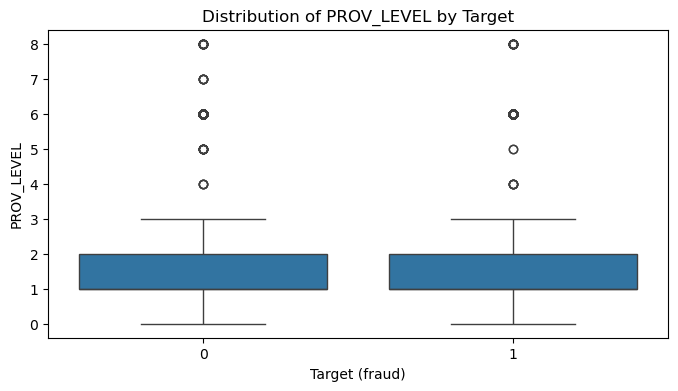

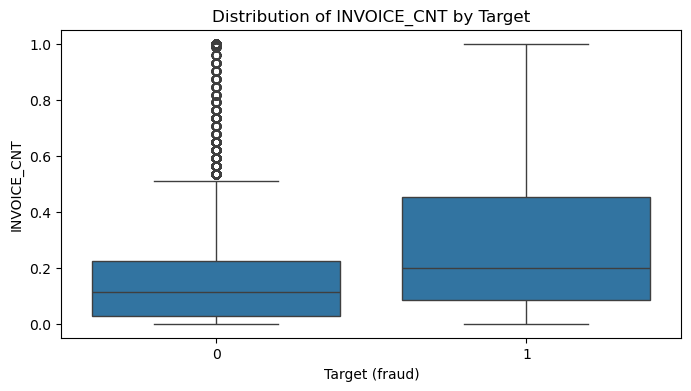

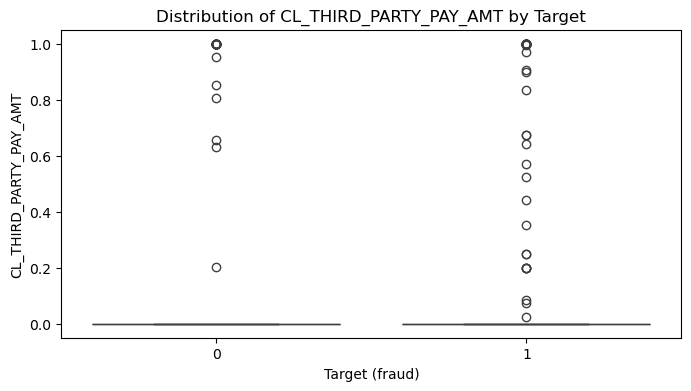

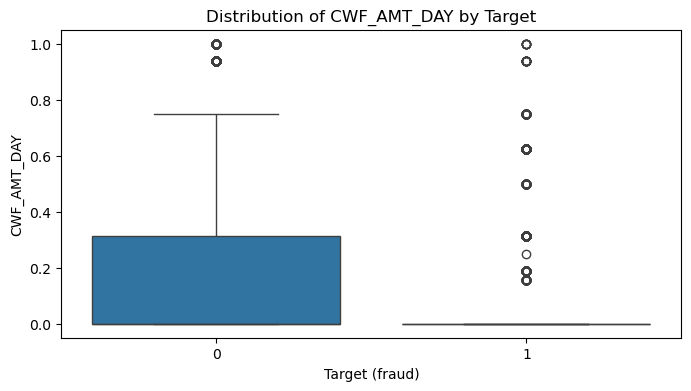

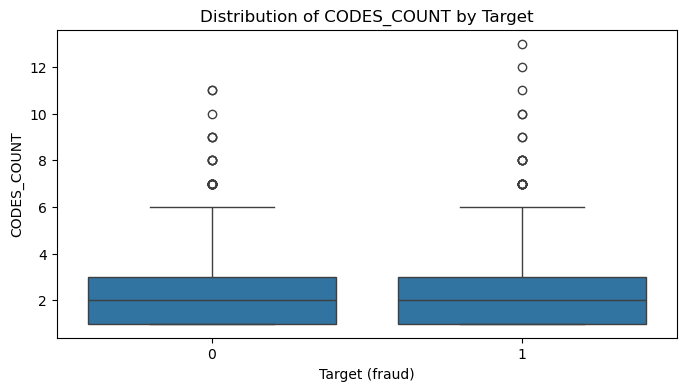

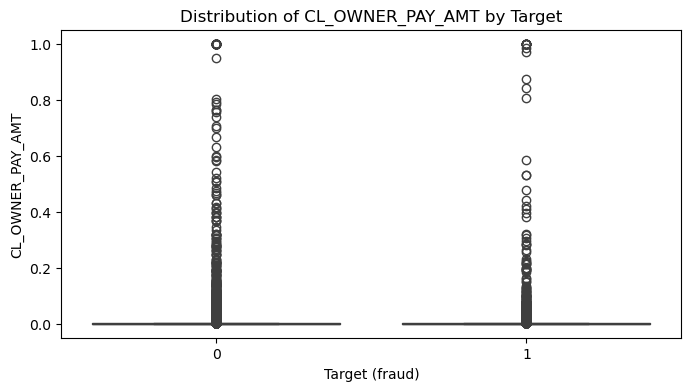

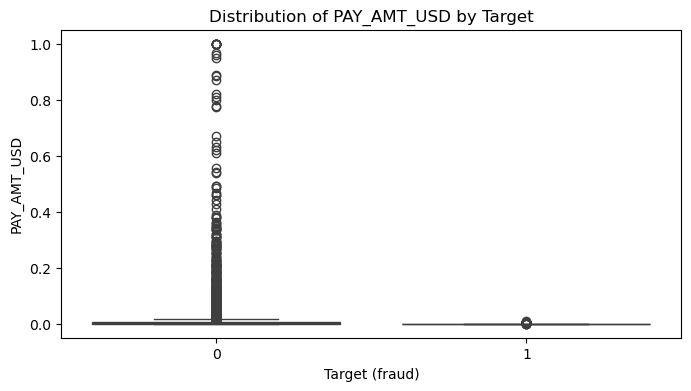

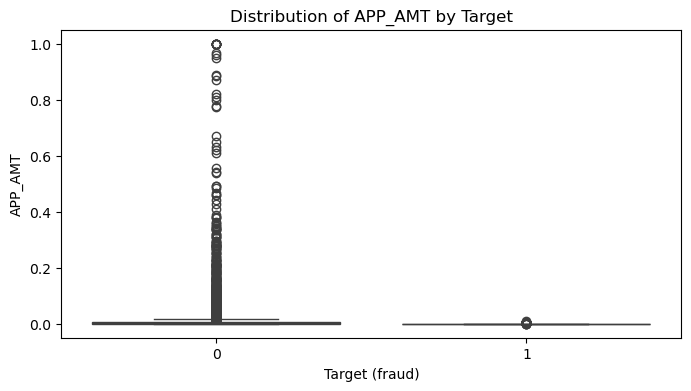

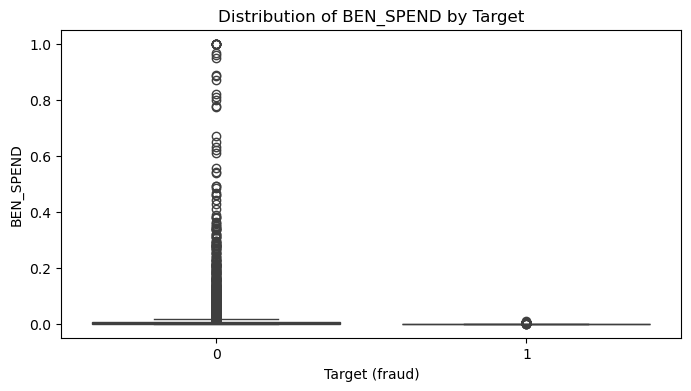

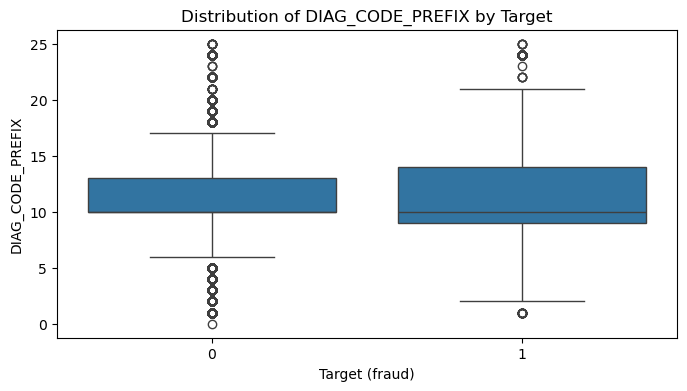

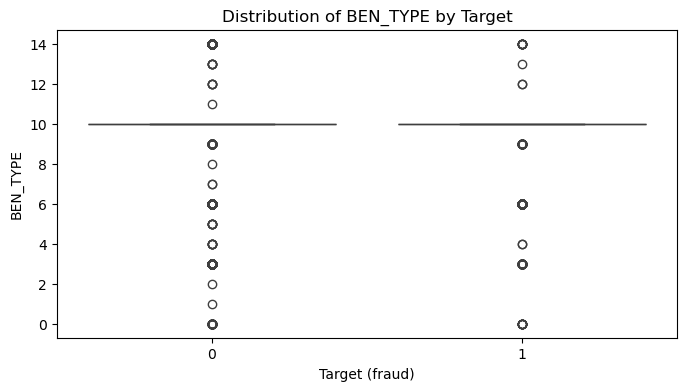

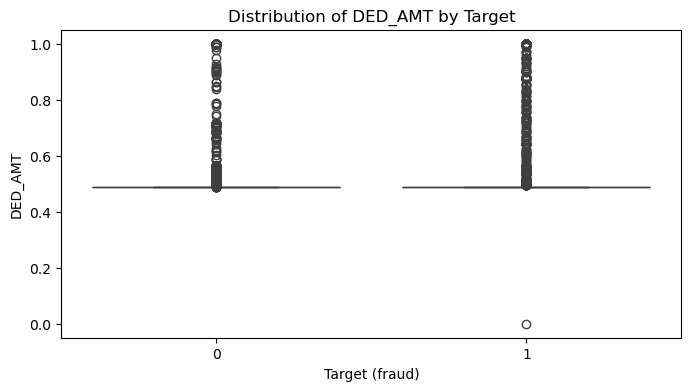

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# p値が0.05未満の特徴量を抽出
significant_features = feature_scores[feature_scores['P值'] < 0.05]

# 有意な特徴量の分布を描画
for feature in significant_features['feature']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=y, y=X[feature])  # 箱ひげ図
    plt.title(f'Distribution of {feature} by Target')
    plt.xlabel('Target (fraud)')
    plt.ylabel(feature)
    plt.show()

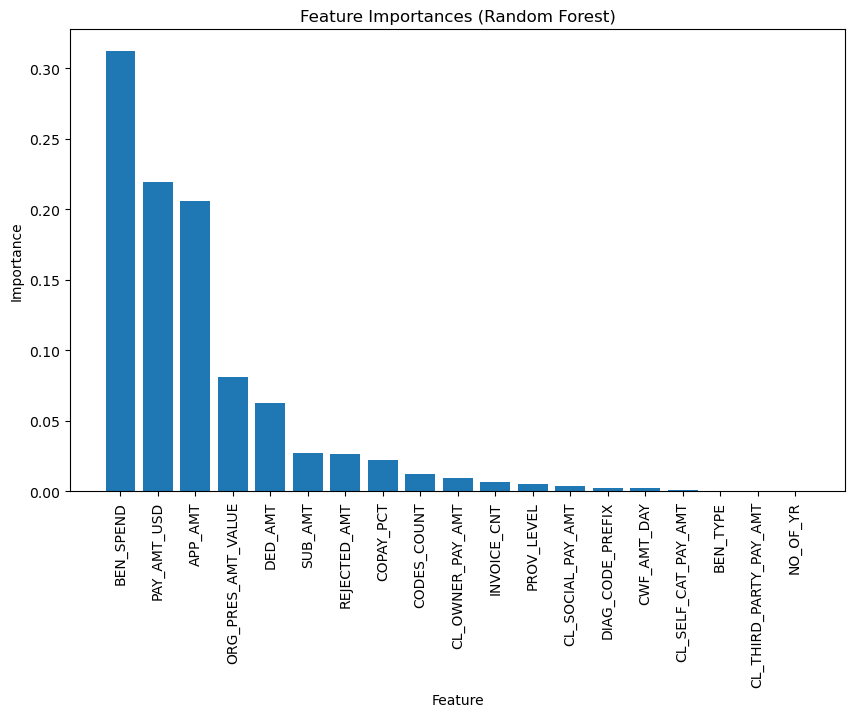

In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# ランダムフォレストモデルの初期化
model = RandomForestClassifier(random_state=42)

# モデルの訓練
model.fit(X, y)

# 特徴量の重要度を取得
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

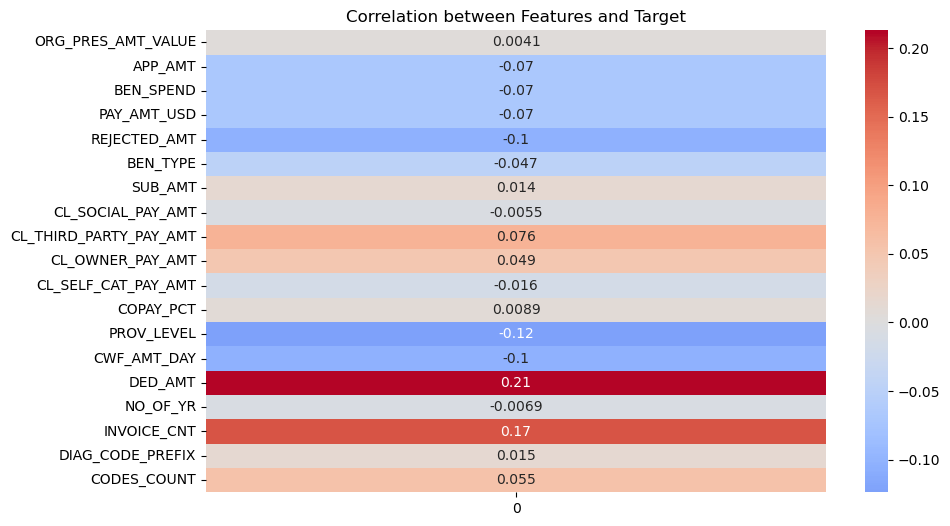

In [14]:
# 特徴量と目的変数の相関を計算
corr = X.corrwith(y)

# 相関ヒートマップを可視化
plt.figure(figsize=(10, 6))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Features and Target")
plt.show()

In [15]:
import pandas as pd

# p値が0.05未満の特徴量を抽出
significant_features = feature_scores[feature_scores['P值'] < 0.05]['feature']

# 元のデータから有意な特徴量列を抽出
final_data = X[significant_features]

# 目的変数 'fraud' を最終データに追加
final_data['fraud'] = y

# xlsxファイルとして保存
final_data.to_excel('最终数据.xlsx', index=False)

print("最终数据已保存为 '最终数据.xlsx'") #最終データは '最终数据.xlsx' として保存されました

最终数据已保存为 '最终数据.xlsx'
